In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
import os
import cv2

def load_images(dirname, filetype=None, grayscale=False, size=None):
    mode = 0 if grayscale else 1
    images = []
    filenames = os.listdir(dirname)
    
    if filetype is not None:
        filenames = [filename for filename in filenames if filename.endswith('.' + filetype)]
        
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename), mode)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        images.append(image)
    
    return images

In [0]:
def prepare_data(c, nc, expand_dims=False, normalization_method=None, return_y=False):
    c  = np.array(c) if type(c) == list else c
    nc = np.array(nc) if type(nc) == list else nc
    
    X = np.concatenate((c, nc), axis=0)
    
    if expand_dims:
        X = np.expand_dims(X, axis=3)
    
    if normalization_method is not None:
        X = X.astype(np.float32)
        
        if normalization_method == 1:
            X = (X - X.min()) / (X.max() - X.min())
        
        elif normalization_method == 2:
            X = 2 * (X - X.min()) / (X.max() - X.min())
            
        elif normalization_method == 3:
            X = (X - X.mean()) / X.std()
    
    if return_y:
        c_label  = np.ones(c.shape[0])
        nc_label = np.zeros(nc.shape[0])
        
        y = np.concatenate((c_label, nc_label), axis=0)
        
        return X, y
    
    return X

In [0]:
results = {}

# Arquitetura 1

Configuração nas imagens do dataset:

*    Tamanho fixo de 128x128
*    Canais RGB
*    Valores regularizados usando a média e o desvio padrão

Modelo:

*   Batch Normalization antes do Max Pooling


In [0]:
c_train = load_images('./Dataset/Train/C', filetype='tif', size=(128, 128))
c_test  = load_images('./Dataset/Train/C', filetype='tif', size=(128, 128))

nc_train = load_images('./Dataset/Train/NC', filetype='tif', size=(128, 128))
nc_test  = load_images('./Dataset/Train/NC', filetype='tif', size=(128, 128))

In [0]:
X, y = prepare_data(c_train, nc_train, normalization_method=3, return_y=True)
X_test, y_test = prepare_data(c_test, nc_test, normalization_method=3, return_y=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=99)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights_architecture_1.hdf5', verbose=1, save_best_only=True)

In [10]:
training = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpointer])

Train on 4809 samples, validate on 535 samples
Epoch 1/30
4809/4809 [==============================] - 12s 2ms/step - loss: 0.3710 - acc: 0.8630 - val_loss: 0.2090 - val_acc: 0.9159

Epoch 00001: val_loss improved from inf to 0.20900, saving model to weights_architecture_1.hdf5
Epoch 2/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.2206 - acc: 0.9137 - val_loss: 0.1976 - val_acc: 0.9215

Epoch 00002: val_loss improved from 0.20900 to 0.19757, saving model to weights_architecture_1.hdf5
Epoch 3/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.2037 - acc: 0.9229 - val_loss: 0.1687 - val_acc: 0.9383

Epoch 00003: val_loss improved from 0.19757 to 0.16875, saving model to weights_architecture_1.hdf5
Epoch 4/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.1875 - acc: 0.9343 - val_loss: 0.2002 - val_acc: 0.9178

Epoch 00004: val_loss did not improve from 0.16875
Epoch 5/30
4809/4809 [==============================] - 8s 2ms/st

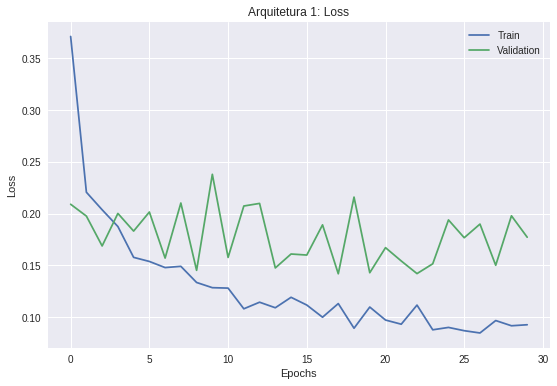

In [11]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Arquitetura 1: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

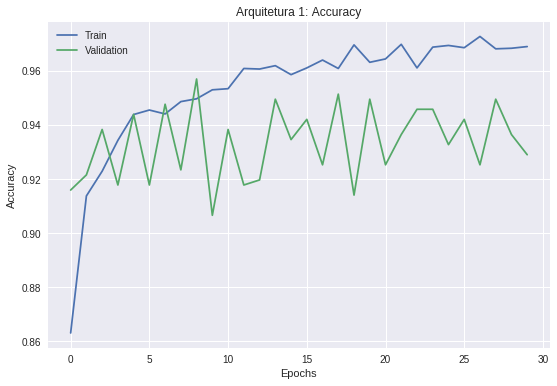

In [12]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Arquitetura 1: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('weights_architecture_1.hdf5')

In [14]:
results['architecture_1'] = model.evaluate(X_test, y_test)

5344/5344 [==============================] - 3s 614us/step


In [15]:
print('Test Loss: {} | Test Accuracy: {:.2f}%'.format(results['architecture_1'][0], 100 * results['architecture_1'][1]))

Test Loss: 0.11284564019454096 | Test Accuracy: 96.28%


# Arquitetura 2

Configuração nas imagens do dataset:

*    Tamanho fixo de 128x128
*    Escala de cinza
*    Valores regularizados usando a média e o desvio padrão

Modelo:

*   Batch Normalization antes do Max Pooling


In [0]:
c_train = load_images('./Dataset/Train/C', filetype='tif', grayscale=True, size=(128, 128))
c_test  = load_images('./Dataset/Train/C', filetype='tif', grayscale=True, size=(128, 128))

nc_train = load_images('./Dataset/Train/NC', filetype='tif', grayscale=True, size=(128, 128))
nc_test  = load_images('./Dataset/Train/NC', filetype='tif', grayscale=True, size=(128, 128))

In [0]:
X, y = prepare_data(c_train, nc_train, expand_dims=True, normalization_method=3, return_y=True)
X_test, y_test = prepare_data(c_test, nc_test, expand_dims=True, normalization_method=3, return_y=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=99)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights_architecture_2.hdf5', verbose=1, save_best_only=True)

In [21]:
training = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpointer])

Train on 4809 samples, validate on 535 samples
Epoch 1/30
4809/4809 [==============================] - 9s 2ms/step - loss: 0.5245 - acc: 0.7979 - val_loss: 0.3508 - val_acc: 0.8579

Epoch 00001: val_loss improved from inf to 0.35080, saving model to weights_architecture_2.hdf5
Epoch 2/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.3454 - acc: 0.8551 - val_loss: 0.2934 - val_acc: 0.8972

Epoch 00002: val_loss improved from 0.35080 to 0.29338, saving model to weights_architecture_2.hdf5
Epoch 3/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.3102 - acc: 0.8715 - val_loss: 0.2631 - val_acc: 0.9103

Epoch 00003: val_loss improved from 0.29338 to 0.26307, saving model to weights_architecture_2.hdf5
Epoch 4/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.2895 - acc: 0.8829 - val_loss: 0.3345 - val_acc: 0.8841

Epoch 00004: val_loss did not improve from 0.26307
Epoch 5/30
4809/4809 [==============================] - 8s 2ms/ste

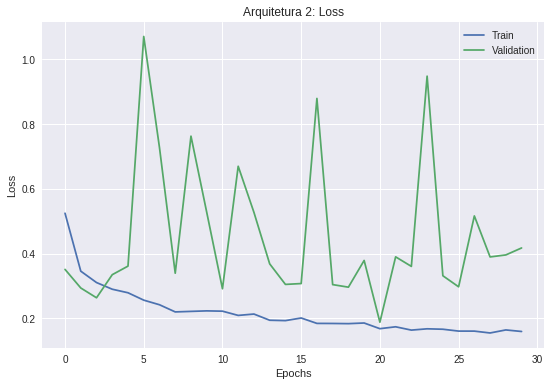

In [22]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Arquitetura 2: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

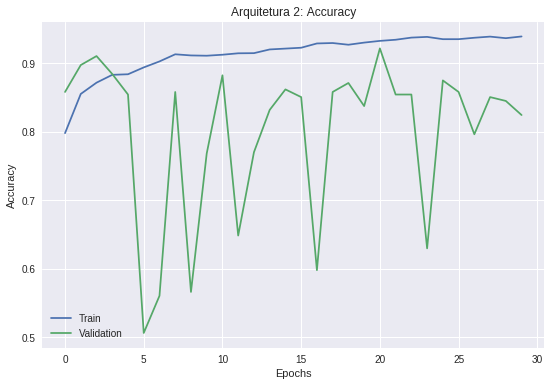

In [23]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Arquitetura 2: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('weights_architecture_2.hdf5')

In [25]:
results['architecture_2'] = model.evaluate(X_test, y_test)

5344/5344 [==============================] - 3s 547us/step


In [26]:
print('Test Loss: {} | Test Accuracy: {:.2f}%'.format(results['architecture_2'][0], 100 * results['architecture_2'][1]))

Test Loss: 0.1857513965380763 | Test Accuracy: 92.05%


# Arquitetura 3

Configuração nas imagens do dataset:

*    Tamanho fixo de 128x128
*    Canais RGB
*    Valores regularizados usando a média e o desvio padrão

Modelo:

*   Batch Normalization depois do Max Pooling


In [0]:
c_train = load_images('./Dataset/Train/C', filetype='tif', size=(128, 128))
c_test  = load_images('./Dataset/Train/C', filetype='tif', size=(128, 128))

nc_train = load_images('./Dataset/Train/NC', filetype='tif', size=(128, 128))
nc_test  = load_images('./Dataset/Train/NC', filetype='tif', size=(128, 128))

In [0]:
X, y = prepare_data(c_train, nc_train, normalization_method=3, return_y=True)
X_test, y_test = prepare_data(c_test, nc_test, normalization_method=3, return_y=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=99)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 64)        256       
__________

In [0]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights_architecture_3.hdf5', verbose=1, save_best_only=True)

In [32]:
training = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[checkpointer])

Train on 4809 samples, validate on 535 samples
Epoch 1/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.3642 - acc: 0.8628 - val_loss: 0.2570 - val_acc: 0.8953

Epoch 00001: val_loss improved from inf to 0.25696, saving model to weights_architecture_3.hdf5
Epoch 2/30
4809/4809 [==============================] - 7s 1ms/step - loss: 0.2438 - acc: 0.9064 - val_loss: 0.1956 - val_acc: 0.9383

Epoch 00002: val_loss improved from 0.25696 to 0.19559, saving model to weights_architecture_3.hdf5
Epoch 3/30
4809/4809 [==============================] - 7s 1ms/step - loss: 0.2050 - acc: 0.9260 - val_loss: 0.1755 - val_acc: 0.9458

Epoch 00003: val_loss improved from 0.19559 to 0.17549, saving model to weights_architecture_3.hdf5
Epoch 4/30
4809/4809 [==============================] - 7s 1ms/step - loss: 0.1858 - acc: 0.9324 - val_loss: 0.2168 - val_acc: 0.9103

Epoch 00004: val_loss did not improve from 0.17549
Epoch 5/30
4809/4809 [==============================] - 7s 1ms/ste

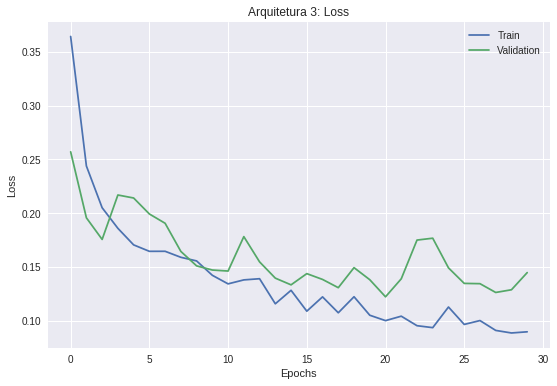

In [33]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Arquitetura 3: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

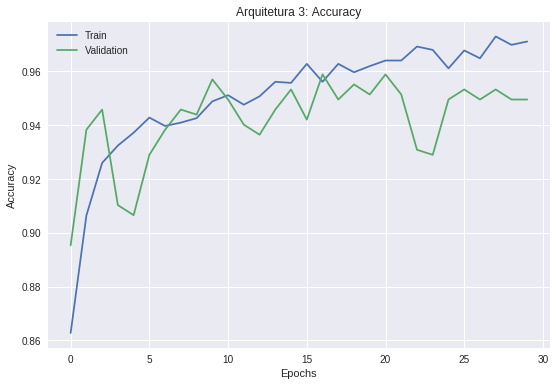

In [34]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Arquitetura 3: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
model.load_weights('weights_architecture_3.hdf5')

In [36]:
results['architecture_3'] = model.evaluate(X_test, y_test)

5344/5344 [==============================] - 3s 526us/step


In [37]:
print("Test Loss: {} | Test Accuracy: {:.2f}%".format(results['architecture_3'][0], 100 * results['architecture_3'][1]))

Test Loss: 0.09481679551682608 | Test Accuracy: 96.73%


# Conclusões

In [38]:
pd.DataFrame(list(results.values()), index=results.keys(), columns=['Loss', 'Accuracy'])

,Loss,Accuracy
architecture_1,0.112846,0.962762
architecture_2,0.185751,0.920472
architecture_3,0.094817,0.967253
